In [26]:
import pandas as pd
import numpy as np
from prophet import Prophet
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns

In [27]:
df = pd.read_excel("AIB_History_Training_2014-2020.xlsx", sheet_name='HistoricalTransactions')
df = df.drop(columns=["FileFolder", "FileName", "Report_Title", "Report_RunDate", "Report_AsOfDate", "Currency", "Institution", "Branch", "TransactionBackdateFlag", "TransactionCode", "TransactionGroup"])
df.set_index("Report_TransactionEffectiveDate", inplace=True)

In [28]:
# Aggregate data by date
daily_data = df.groupby('Report_TransactionEffectiveDate')['TransactionAmount'].sum().reset_index()
daily_data.columns = ['ds', 'y']
daily_data = daily_data.sort_values('ds')
daily_data

,ds,y
0,2013-12-30,-1076.913729
1,2013-12-31,-41733.273687
2,2014-01-01,-3465.890925
3,2014-01-02,-45506.653405
4,2014-01-03,-18386.381900
...,...,...
1779,2020-12-25,1613.384621
1780,2020-12-26,1763.692730
1781,2020-12-29,82156.304473
1782,2020-12-30,22316.790026


In [29]:
# Fill missing dates with 0
date_range = pd.date_range(start=daily_data['ds'].min(), end=daily_data['ds'].max(), freq='D')
daily_data = daily_data.set_index('ds').reindex(date_range, fill_value=0).reset_index()
daily_data.columns = ['ds', 'y']
daily_data 

,ds,y
0,2013-12-30,-1076.913729
1,2013-12-31,-41733.273687
2,2014-01-01,-3465.890925
3,2014-01-02,-45506.653405
4,2014-01-03,-18386.381900
...,...,...
2554,2020-12-27,0.000000
2555,2020-12-28,0.000000
2556,2020-12-29,82156.304473
2557,2020-12-30,22316.790026


In [30]:
# Split data into training and validation sets
validation_size = 90  # Change this to adjust validation period
train_data = daily_data[:-validation_size].copy()
validation_data = daily_data[-validation_size:].copy()

In [31]:
# Create and train the model
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10,
    holidays_prior_scale=10
)
model.add_country_holidays(country_name='US')
model.fit(train_data)

23:02:25 - cmdstanpy - INFO - Chain [1] start processing
23:02:25 - cmdstanpy - INFO - Chain [1] done processing


In [32]:
# Make predictions for validation period
future_validation = model.make_future_dataframe(periods=validation_size)
validation_forecast = model.predict(future_validation)
validation_predictions = validation_forecast[-validation_size:]

In [33]:
# Calculate evaluation metrics
actual_values = validation_data['y'].values
predicted_values = validation_predictions['yhat'].values

In [34]:
mae = mean_absolute_error(actual_values, predicted_values)
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100
r2 = r2_score(actual_values, predicted_values)

C:\Users\Andy\AppData\Local\Temp\ipykernel_8280\2006467214.py:3: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100


In [35]:
print("\nModel Evaluation Metrics:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R2 Score: {r2:.2f}")


Model Evaluation Metrics:
MAE: 15928.79
RMSE: 26920.01
MAPE: inf%
R2 Score: 0.18


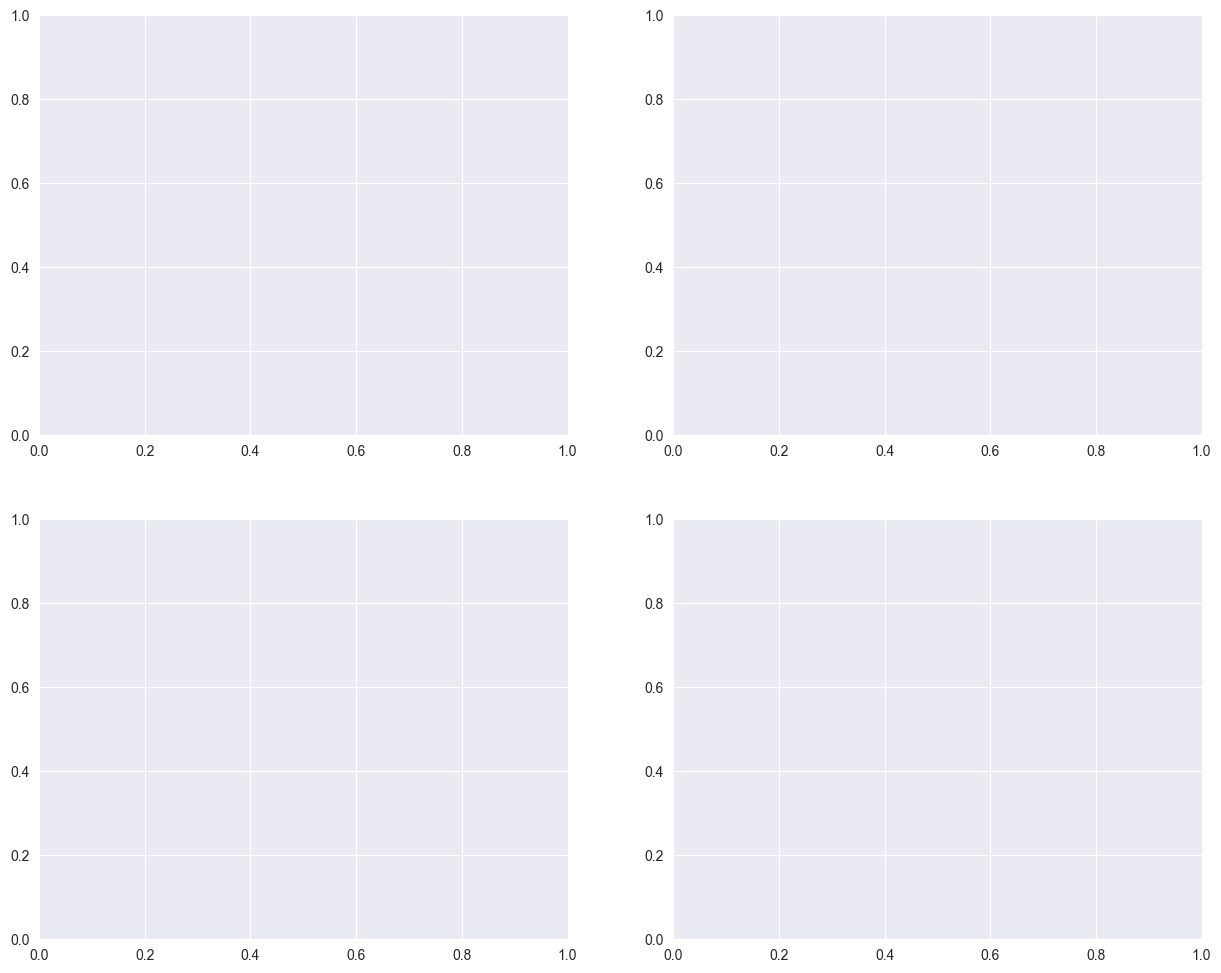

In [36]:
# Create evaluation plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

In [37]:
# 1. Actual vs Predicted Values
axes[0, 0].scatter(actual_values, predicted_values, alpha=0.5)
axes[0, 0].plot([actual_values.min(), actual_values.max()], 
                [actual_values.min(), actual_values.max()], 'r--')
axes[0, 0].set_xlabel('Actual Values')
axes[0, 0].set_ylabel('Predicted Values')
axes[0, 0].set_title('Actual vs Predicted Values')
axes[0, 0].grid(True)


In [38]:
# 2. Residuals Plot
residuals = actual_values - predicted_values
axes[0, 1].scatter(predicted_values, residuals, alpha=0.5)
axes[0, 1].axhline(y=0, color='r', linestyle='--')
axes[0, 1].set_xlabel('Predicted Values')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residuals vs Predicted Values')
axes[0, 1].grid(True)

In [39]:
# 3. Time Series of Residuals
axes[1, 0].plot(validation_data['ds'], residuals)
axes[1, 0].axhline(y=0, color='r', linestyle='--')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Residuals')
axes[1, 0].set_title('Residuals Over Time')
axes[1, 0].grid(True)
plt.setp(axes[1, 0].xaxis.get_majorticklabels(), rotation=45)

[None, None, None, None, None, None, None]

In [40]:
# 4. Residuals Distribution
sns.histplot(residuals, kde=True, ax=axes[1, 1])
axes[1, 1].axvline(x=0, color='r', linestyle='--')
axes[1, 1].set_xlabel('Residuals')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Residuals')

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [41]:
# Plot validation results
plt.figure(figsize=(15, 8))


<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

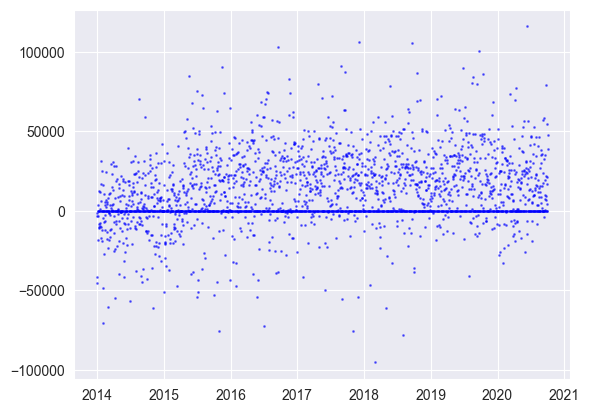

In [42]:
# Plot training data
plt.plot(train_data['ds'], 
         train_data['y'], 
         'b.', 
         label='Training Data', 
         alpha=0.5,
         markersize=2)

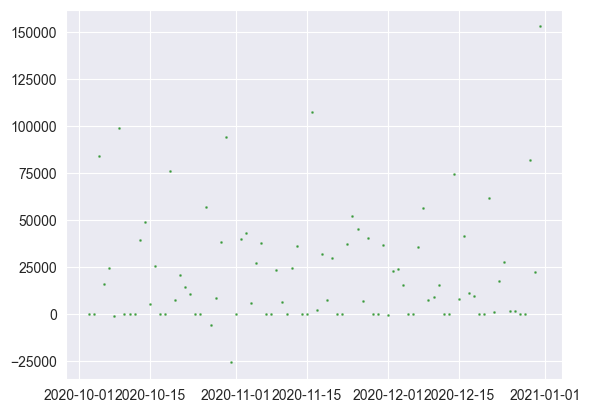

In [43]:
# Plot validation data
plt.plot(validation_data['ds'], 
         validation_data['y'], 
         'g.', 
         label='Validation Data', 
         alpha=0.5,
         markersize=2)

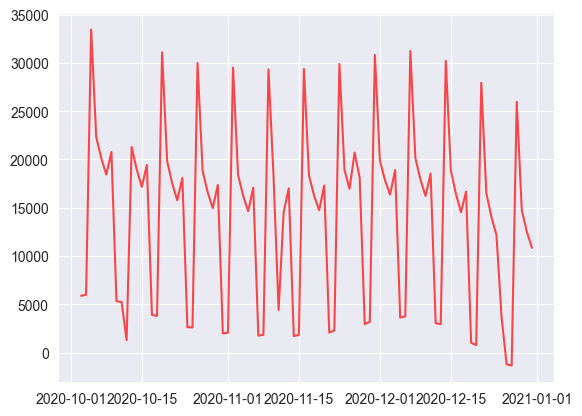

In [44]:
# Plot predictions
plt.plot(validation_predictions['ds'], 
         validation_predictions['yhat'], 
         'r-', 
         label='Predictions', 
         alpha=0.7)

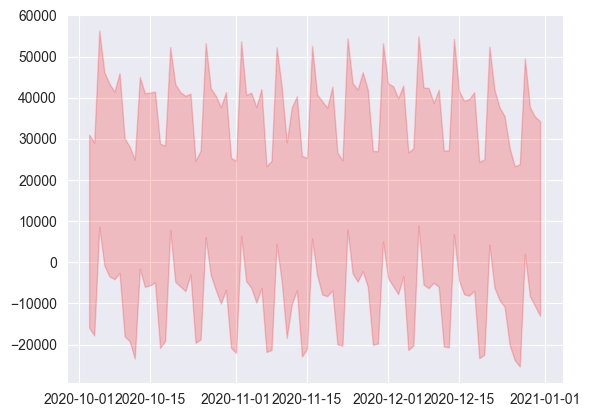

In [45]:
# Plot confidence intervals
plt.fill_between(validation_predictions['ds'],
                validation_predictions['yhat_lower'],
                validation_predictions['yhat_upper'],
                color='r',
                alpha=0.2,
                label='Confidence Interval')

C:\Users\Andy\AppData\Local\Temp\ipykernel_8280\1577267739.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


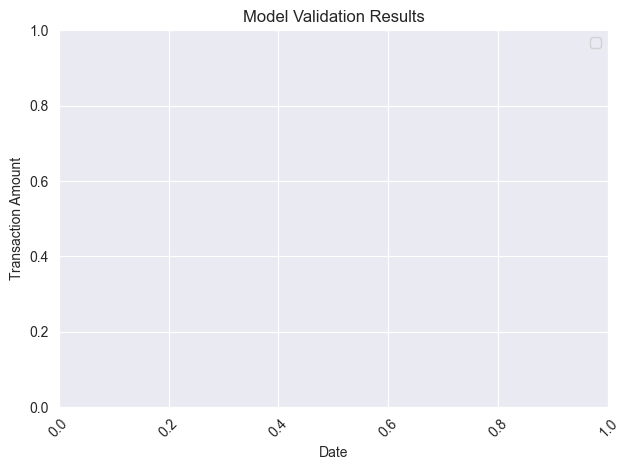

In [46]:
plt.title('Model Validation Results')
plt.xlabel('Date')
plt.ylabel('Transaction Amount')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [47]:
# Generate future forecast
forecast_periods = 90  # Change this to adjust forecast period
future = model.make_future_dataframe(periods=forecast_periods)
forecast = model.predict(future)

In [48]:
# Plot final forecast
plt.figure(figsize=(15, 8))

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

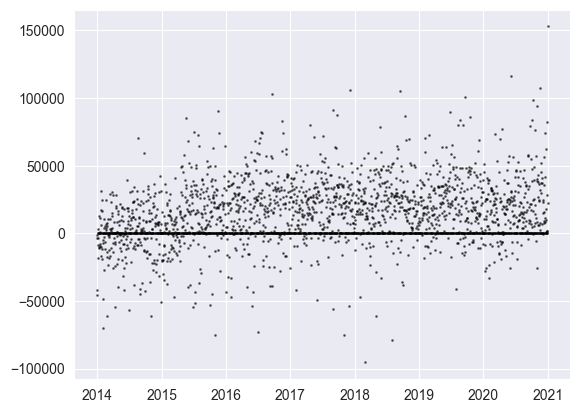

In [49]:
# Plot historical data
plt.plot(daily_data['ds'], daily_data['y'], 'k.', 
         label='Historical Data', alpha=0.5, markersize=2)

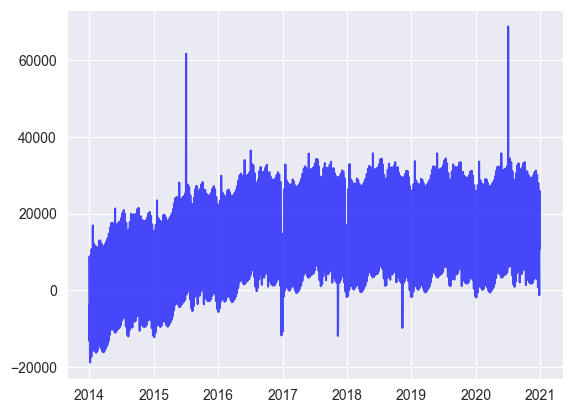

In [50]:
# Plot fitted values
historical_dates = daily_data['ds']
fitted_values = forecast[forecast['ds'].isin(historical_dates)]['yhat']
plt.plot(historical_dates, fitted_values, 'b-', 
         label='Fitted Values', alpha=0.7)

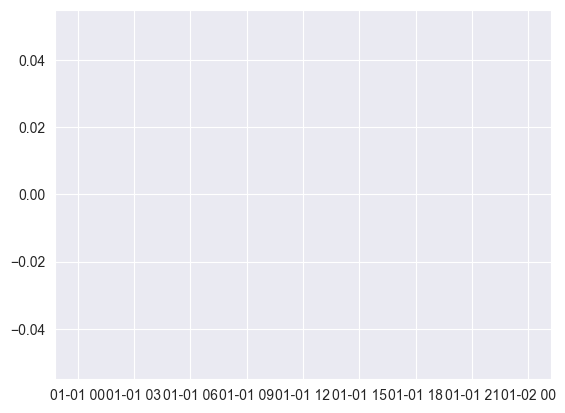

In [51]:
# Plot future forecast
future_dates = forecast['ds'][len(daily_data):]
future_values = forecast['yhat'][len(daily_data):]
plt.plot(future_dates, future_values, 'r-', 
         label='Future Forecast', alpha=0.7)

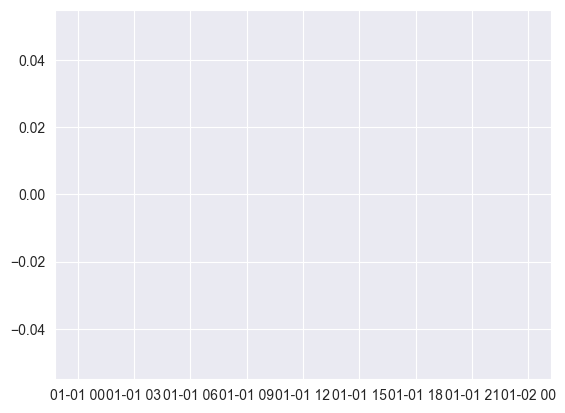

In [52]:
# Plot confidence intervals for future forecast
plt.fill_between(future_dates,
                forecast['yhat_lower'][len(daily_data):],
                forecast['yhat_upper'][len(daily_data):],
                color='r',
                alpha=0.2,
                label='Forecast Confidence Interval')

C:\Users\Andy\AppData\Local\Temp\ipykernel_8280\3116625566.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


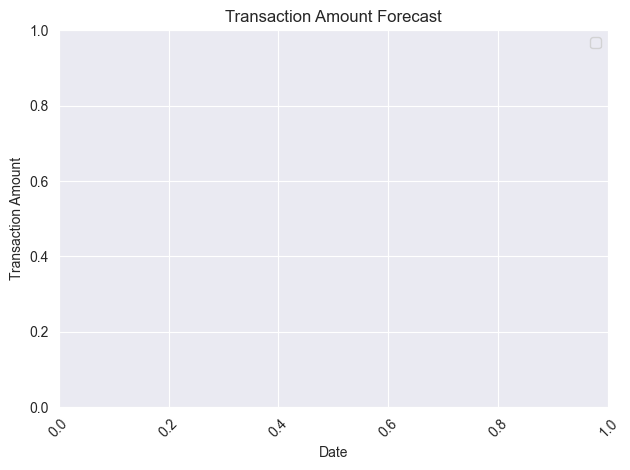

In [53]:
plt.title('Transaction Amount Forecast')
plt.xlabel('Date')
plt.ylabel('Transaction Amount')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()